# Impacts of activity cliff and stereochemistry in QSAR models
__Stereoisomerization__ refers to the phenomenon where molecules with the same molecular formula and connectivity (i.e., the same sequence of bonded atoms) differ in the spatial arrangement of their atoms, leading to the existence of stereoisomers. Stereoisomers are a type of isomer where the differences arise not from the sequence of bonds but from the orientation of atoms in three-dimensional space.

__Activity cliff__ (ACs) were generally defined as pairs of structurally similar active compounds with a large difference in potency. The existence of ACs directly defies the intuitive idea that chemical compounds with similar structures should have similar activities, often referred to as the molecular similarity principle. As such, ACs received strong attention in computational chemistry and drug design [Stumpfe et al. 2019](https://pubs.acs.org/doi/10.1021/acsomega.9b02221).

In this notebook, we explore the various types of stereoisomerization, how stereochemical information can be captured through molecular representations. We also examine the impact of stereoisomers that exhibit significant activity cliffs (ACs) in QSAR modeling.

In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from copy import copy


import datamol as dm
from molfeat.trans.fp import FPVecTransformer

from utils import add_3d_coord

## Stereoisomerization

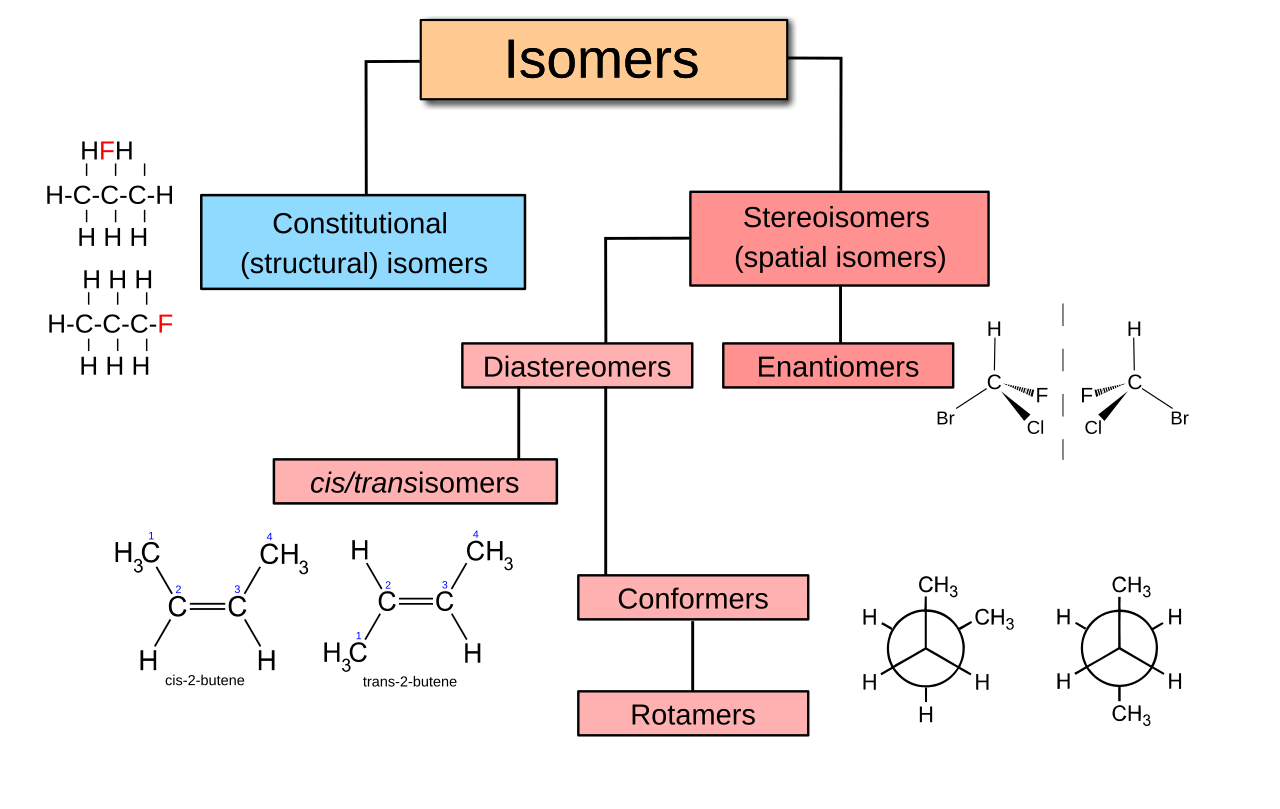
Image from https://en.wikipedia.org/wiki/Stereoisomerism

In [2]:
## Example: a pair of stereoisomers
mol1 = dm.to_mol("CC(C(=O)O)[C@H](N)C")
mol2 = dm.to_mol("CC(C(=O)O)[C@@H](N)C")

## Add 3d coordinates to the molecules
mol1_3d = add_3d_coord(mol=dm.copy_mol(mol1))
mol2_3d = add_3d_coord(mol=dm.copy_mol(mol2))

The stereochemical information can be specified in SMILES strings, such as `C@H` and `C@@H` for enantiomers.

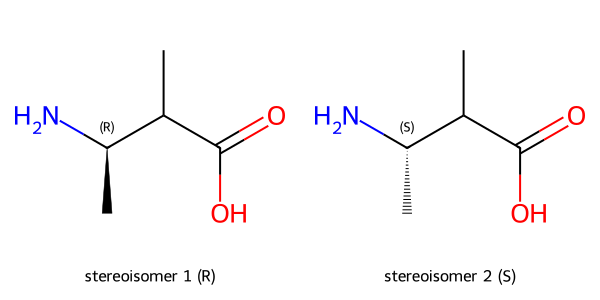

In [3]:
dm.to_image(
    [mol1, mol2], n_cols=2, legends=["stereoisomer 1 (R)", "stereoisomer 2 (S)"]
)

In [4]:
# We can verify if the two molecules are identical by `dm.same_mol`
if not dm.same_mol(mol1_3d, mol2_3d):
    print("The two molecules are not identical!")

The two molecules are not identical!


Similarily,  E/Z isomers can be specified by `/` and `\` in SMILES strings.



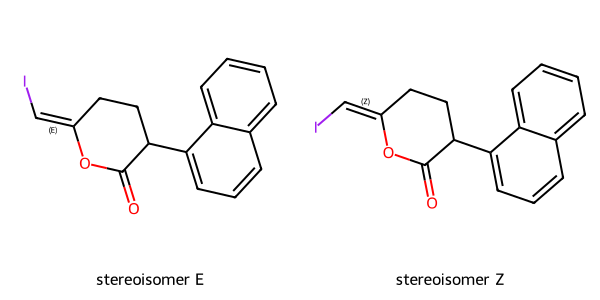

In [5]:
## Example: a pair of stereoisomers
mol3 = dm.to_mol("O=C1O/C(=C/I)CCC1c1cccc2ccccc12")
mol4 = dm.to_mol("O=C1O/C(=C\\I)CCC1c1cccc2ccccc12")


mol3_3d = add_3d_coord(mol=dm.copy_mol(mol3))
mol4_3d = add_3d_coord(mol=dm.copy_mol(mol4))

dm.to_image([mol3, mol4], n_cols=2, legends=["stereoisomer E", "stereoisomer Z"])

## Stereisomers with activity cliff and the impact on QSAR 

Stereoisomers with activity cliffs can pose challenges to QSAR modeling by creating sharp contrasts in biological activity that are not easily captured by standard models. Accurate representation of stereochemistry and careful model design are crucial for addressing these challenges and improving the predictive accuracy and interpretability of QSAR models.

### Choice of molecular representations for stereoisomerization

**Featurizer 1**: Let’s use the ECFP featurizer, which encodes the presence of specific substructures or features in a molecule. It is one of the most commonly used molecular representations in QSAR modeling.

In [6]:
from molfeat.trans import FPVecTransformer

transfomer_1 = FPVecTransformer(kind="ecfp:4", length=2042)
fp1 = transfomer_1(mol1_3d)
fp2 = transfomer_1(mol2_3d)
if np.array_equal(fp1, fp2):
    print(
        f"This featurizer '{transfomer_1.kind}' can't differenciate the two enantiomers!"
    )

This featurizer 'ecfp:4' can't differenciate the two enantiomers!


In [7]:
fp3 = transfomer_1(mol3_3d)
fp4 = transfomer_1(mol4_3d)
if np.array_equal(fp3, fp4):
    print(
        f"This featurizer '{transfomer_1.kind}' can't differenciate the two diastereoisomers!"
    )

This featurizer 'ecfp:4' can't differenciate the two diastereoisomers!


Now let’s explore more sophisticated featurizers that captures the 3D information of molecules.

**Featurizer 2**: 3D version of the CATS pharmacophores computed with the Pharm2D module in RDKit.

In [8]:
from molfeat.trans.base import MoleculeTransformer
from molfeat.calc.pharmacophore import Pharmacophore3D

# define transformer
transformer_2 = MoleculeTransformer(
    featurizer=Pharmacophore3D(factory="cats"), dtype=float
)
feat1 = transformer_2(mol1_3d)
feat2 = transformer_2(mol2_3d)
if not np.array_equal(feat1, feat2):
    print(
        f"This featurizer '{transformer_2.featurizer.factory}' can differenciate the enantiomers!"
    )

This featurizer 'cats' can differenciate the enantiomers!


In [9]:
feat3 = transformer_2(mol3_3d)
feat4 = transformer_2(mol4_3d)
if not np.array_equal(feat1, feat2):
    print(
        f"This featurizer '{transformer_2.featurizer.factory}' can differenciate the diastereoisomers!"
    )

This featurizer 'cats' can differenciate the diastereoisomers!


Please find more deatails about featurizer [pharm3D-cats](https://molfeat.datamol.io/featurizers/pharm3D-cats) and explore other available featurizers on [molfeat](https://molfeat.datamol.io/) page.

###  QSAR modeling with stereoisomers exhibiting activity cliffs

In this section, we’ll take a closer look at how activity cliffs between stereoisomers can impact the predictive performance of QSAR modeling. 

In [32]:
# load data set of small molecule inhibitors of dopamine receptor D2
data = pd.read_csv("data/dopamine_d2_data.csv")

In [33]:
mol_col = "MOL_smiles"
val_col = "CLS_pChEMBL Value"

mols = dm.utils.parallelized(
    fn=lambda mol: add_3d_coord(mol),
    inputs_list=data[mol_col],
    progress=True,
    n_jobs=10,
)
data["mol"] = mols

  0%|          | 0/7017 [00:00<?, ?it/s]

[21:02:17] UFFTYPER: Unrecognized charge state for atom: 21
[21:02:17] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:17] UFFTYPER: Unrecognized charge state for atom: 21
[21:02:17] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:17] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:17] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:19] UFFTYPER: Unrecognized charge state for atom: 11
[21:02:19] UFFTYPER: Unrecognized charge state for atom: 11
[21:02:21] UFFTYPER: Unrecognized charge state for atom: 11
[21:02:21] UFFTYPER: Unrecognized charge state for atom: 11
[21:02:21] UFFTYPER: Unrecognized charge state for atom: 15
[21:02:21] UFFTYPER: Unrecognized charge state for atom: 15
[21:02:28] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:28] UFFTYPER: Unrecognized charge state for atom: 10
[21:02:29] UFFTYPER: Warning: hybridization set to SP3 for atom 27
[21:02:29] UFFTYPER: Warning: hybridization set to SP3 for atom 27
[21:02:29] UFFTYPER: Warni

In [44]:
# the dataset was split to train/test by the presence of activity cliffs
data_train = data.query("split == 'train'")
data_test = data.query("split == 'test'")

In [13]:
data.groupby("split")["AC_CLS_pChEMBL Value"].value_counts()

split  AC_CLS_pChEMBL Value
test   False                   1361
       True                     103
train  False                   5451
       True                     102
Name: count, dtype: int64

#### Training with simple RandomForest model

To evaluate the impact of including stereochemistry information on prediction performance, we will train two QSAR models using the same machine learning algorithm and parameters. One model will use the `ECFP:4` featurizer, which does not capture stereochemistry, while the other will use the `pharm3D-cats` featurizer, which includes 3D stereochemical information.

In [14]:
# Define the model with specified parameters

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    criterion="gini",
    verbose=True,
    n_jobs=-1,
)

**Model 1**: `RandomForestClassifier` + `ECFP:4`

In [15]:
# Transform with featurizer which can't differe stereoisomers
transformer_1 = FPVecTransformer(kind="ecfp:4", dtype=float)
X_train = transformer_1(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values

model_1 = copy(model)
# Fit the model
model_1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

**Model 2**: `RandomForestClassifier` + `pharm3D-cats`

In [16]:
X_train = transformer_2(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values
model_2 = copy(model)
# Fit the model
model_2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

#### Compare the predictive performance on test set

In [17]:
results = {"overall": {}, "non-AC": {}, "AC": {}}

#### Overall performance on entire test set

In [18]:
from utils import evaluate

results["overall"]["rf+ecfp"] = evaluate(
    data_test, transformer_1, model_1, mol_col="mol"
)

results["overall"]["rf+pharm3Dcats"] = evaluate(
    data_test, transformer_2, model_2, mol_col="mol"
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [19]:
pd.DataFrame(results["overall"])

,rf+ecfp,rf+pharm3Dcats
precision,0.807242,0.754826
recall,0.799259,0.716050
f1-score,0.802565,0.722976
support,1464.000000,1464.000000


#### Performance on stereoisomers which show activity cliff

In [20]:
results["AC"]["rf+ecfp"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_1,
    model_1,
    mol_col="mol",
)
results["AC"]["rf+pharm3Dcats"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_2,
    model_2,
    mol_col="mol",
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
pd.DataFrame(results["AC"])

,rf+ecfp,rf+pharm3Dcats
precision,0.301209,0.425788
recall,0.301509,0.432453
f1-score,0.300905,0.421124
support,103.000000,103.000000


QSAR modeling for molecules sensitive to stereochemical information and those exhibiting activity cliffs is always challenging. The results above demonstrate that while the model trained with `pharm3D-cats` underperformed in overall prediction accuracy, it significantly outperformed when predicting the activity of stereoisomers with activity cliffs. This highlights the importance of using molecular representations that effectively capture stereochemistry in such scenario.

Careful data curation and auditing are essential to determine whether bioactivity in a given dataset is sensitive to stereochemistry. `Auroris` simplifies and streamlines this process by providing the [StereoIsomerACDetection](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L61) module and the corresponding  [detect_streoisomer_activity_cliff](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L15) function to easily assess this issue. For guidance on how to combine different Auroris modules for small molecule dataset curation, please checkout this [tutorial](https://polaris-hub.github.io/auroris/stable/tutorials/getting_started.html).

The end.